# CPEN400D Deep Learning

Instructors: Brad Quinton, Scott Chin

# Assignment 3: Deep Neural Networks, Multiclass Classification, and Keras

In the previous assignment, you built a 2-layer Neural Network for binary classification. However, the forward propagation and backward propagation steps were implemented in a flat manner and hardcoded for exactly two layers. In this assignment, we will break down the network into individual layer types, and implement forward and backward propagation for each layer type separately. Then, we can construct deep neural networks by mixing and matching the layers you have defined.  

The goal of this assignment is 
- to help you better understand the backpropagation of each layer type.
- reinforce the notion that backpropagation is a very local process. 
- show you the fundamentals of what is going on behind high-level deep learning frameworks as our framework is modelled after the TensorFlow Keras high-level deep learning library. 

Specifically, after this assignment you will have:

- Built a modular Neural Network framework that supports basic layer types and components.
- Implemented forward propagation and back propagation in a modular and vectorized fashion for common layer types.
- Implemented new functionalities such as ReLU activation, softmax activation, and categorical cross entropy loss.
- Built a multiclass classifier for both structured data, and unstructured image data.
- Explored limitations of classic Gradient Descent, and naive weight initialization for deep neural networks.
- Worked with a real dataset (MNIST) and applied training and validation data sets to evaluate a model
- Used Keras to build and train basic neural networks


## 0. Completing Your Assignment

Your assignment will be graded based on your implementation and completion of specific code cells within this Jupyter Notebook. The code cells that you need to complete will start with the following text:

**\# GRADED FUNCTION:**

Only these cells will be extracted and graded.  Furthermore, within these code cells will be comments 

**\### START CODE HERE ###** and **\### END CODE HERE ###**

Write your code **between** these comments!  Do **NOT** change any of the code outside of these comments! 

Above these comments, we will also estimate the number of lines of code that you will need to write. We don't check line count, but if you find yourself going significantly beyond these suggestions, you may consider rethinking your approach.

Submit your assignment via JupyterHub.  You can submit as many times as you'd like.  We will grade the most recently submitted version. **REMEMBER TO CLICK THE SUBMIT BUTTON!!!**

Please also edit the following code cell to include your name and student number.  Thank you!

In [1]:
# Student Name: Berkay Talha ACAR
# Student Number: 28681344

## Summary of Graded Functions

| Function                 | Marks | 
|-------------------------|-------|
| linear_forward_propagate | 2 |
| linear_backward_propagate| 2 |
| relu_forward_propagate | 2 |
| relu_backward_propagate | 2 |
| tanh_forward_propagate | 2 |
| tanh_backward_propagate | 2 |
| softmax_forward_propagate | 2 |
| softmax_backward_propagate | 4 |
| categorical_forward_propagate | 2 |
| categorical_backward_propagate | 4 |
| Keras | 1 |
| TOTAL | 25 |

## 1 Deep Neural Network Framework Overview 

A number of classes make up our Deep Learning Framework and the class hierarchy is shown below.

<div>
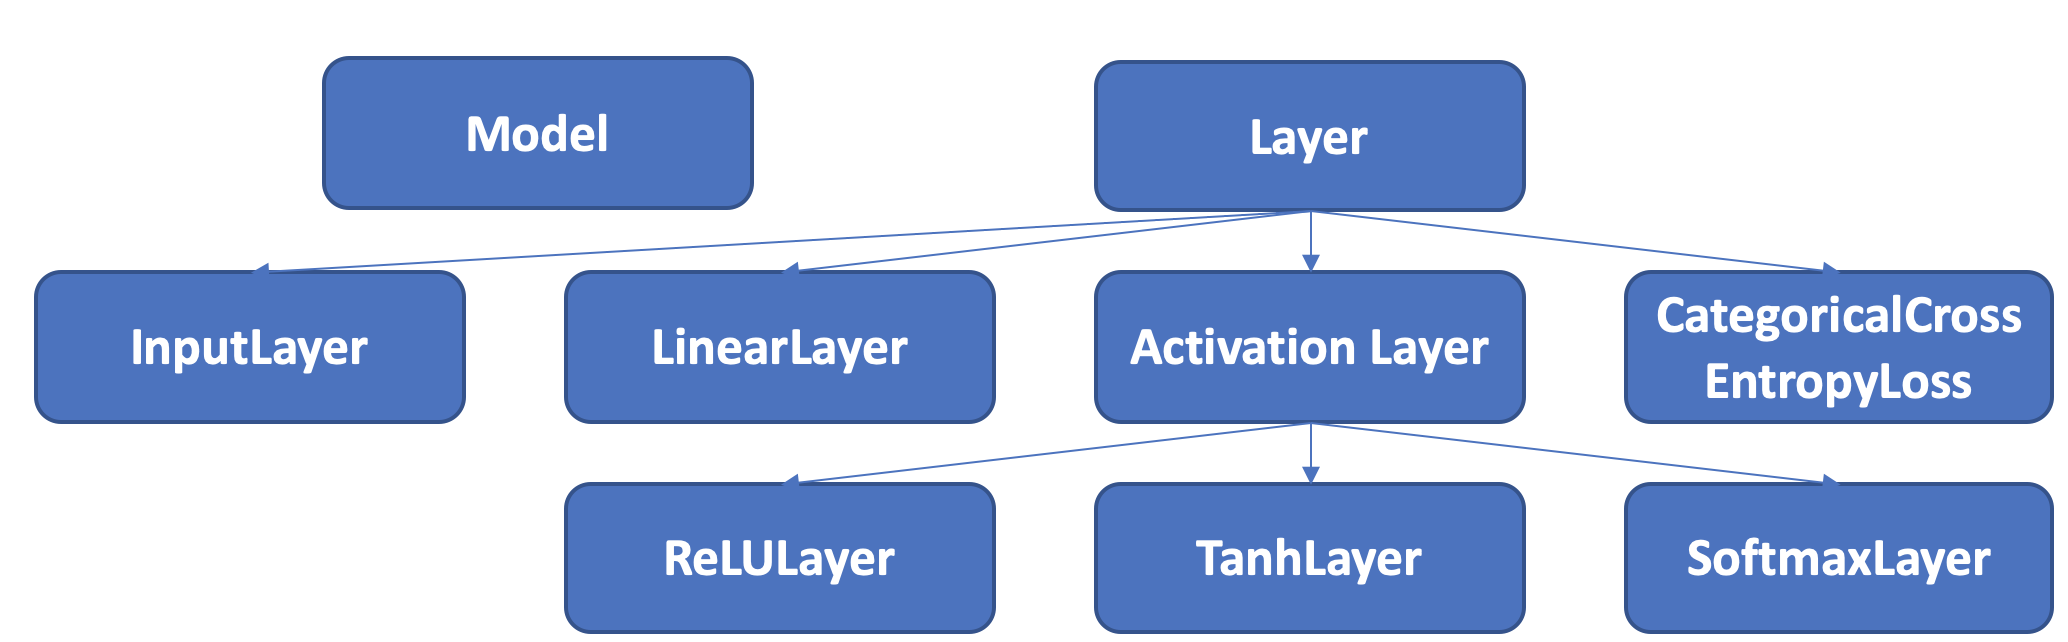
</div>

The assignment is set up so that you do not need to look at or interact with any code except the forward and backward propagate functions that you need to implement. You are welcome to take a look at the supporting code of course if you are curious! Here is a brief description of the framework.

- The Layer and ActivationLayer classes are abstract base class. 
- LinearLayer models the linear portion of a fully-connected layer.  i.e. the z=Wx+b portion. We have split the activation (e.g. ReLU, tanh, softmax) part of a fully-connected layer into a separate layer in our framework for ease of delivering to you for implementation. Note that the learned parameters of the fully connected layer are stored in LinearLayer.
- ReLULayer, TanhLayer, SoftmaxLayer implement the ReLU, tanh, and softmax activations, respectively. i.e. a = g(z) where g() is the activation function.
- InputLayer is simply used to model information about the input feature shape (e.g. number of features in the input).
- CategoricalCrossEntropyLoss models the Categorical Cross Entropy Loss cost function. We model this as a layer since we want to do backpropagation starting from the cost.
- The Model class models the neural network itself. It is instantiated with a collection of the above layers, and it manages the overall training and prediction of the network.

The only parts you will need to implement are the forward_propagate() and backward_propagate() functions of the following classes:
- LinearLayer
- ReLULayer
- TanhLayer
- SoftmaxLayer
- CategoricalCrossEntropyLoss

You can tackle the above classes in any order that you'd like. But this is my suggested order based on difficulty.
For each class, you will need to get forward propagate working first before backward propagate. The reason is that backward propagate should depend on some values computed during forward propagate. The framework is structured to cache some values during forward propagate to send to their corresponding backward propagate functions. Furthermore, the built in tests that we have provided for the backprop functions expect the corresponding forward prop function to work first.

The framework has been provided as a collection of Python .py files outside of this notebook.  The functions that you need to implement are set up as static functions inside the Jupyter notebook, and are then inserted into their respective classes. You don't need to understand this process. We just mention it in case you are curious.


#### 1.1 How this will all come together in the end

Once you have implemented the forward and backward propagation functions, you will be able to mix and match layers to build and train arbitrarily complex models.  Here is an example code:

    nnmodel = Model([
        InputLayer(2),     # 2 Input features
        LinearLayer(50),   # z1 = w1  x + b1,  50 units
        ReLULayer(),       # a1 = relu(z1)
        LinearLayer(30),   # z2 = w2 a1 + b2, 30 units
        ReLULayer(),       # a2 = relu(z2)
        LinearLayer(3),    # z3 = w3 a2 + b3, 3 output nodes (i.e. 3 output classes)
        SoftmaxLayer()])   # a3 = softmax(z3)
 
    # Compile model using Categorical Cross Entropy Loss
    nnmodel.compile(loss=CategoricalCrossEntropyLoss())
    
    # Train for 200 gradient descent iterations using learning rate of 0.2
    nnmodel.train(X_train, Y_train, validation_data=(X_validation, Y_validation), epochs=200, learning_rate=0.2)

    # Use the model for prediction on some new data
    nnmodel.predict(X)
    


### 1.2. Caching values between forward_propagate() and backward_propagate()

During forward propagation, you may want to cache some values to be used during backward propagation.  We will let you decide which values to cache. The framework is designed so that forward_propagate() functions all initialize and return a cache object.  The cache object will be automatically passed to the corresponding backward propagate function via an input argument. This is all handled for you.  You just need to choose which objects to cache, and write the code to perform the actual caching.  See below for examples.

#### 1.2.1 Example of caching one object

For example, to save one numpy array stored in variable named x during linear_forward_propagate():

    def linear_forward_propagate(x, w, b):
        cache = None 

        ### START CODE HERE ###
        ...
        cache = x  # <-- This is what you write. Caching x
        
        ### END CODE HERE ###
        
        return z, cache 
        
The cache object in linear_forward_propagate() will automatically be passed to linear_backward_propagate(). To load load x during linear_backward_propagate():

    def linear_backward_propagate(dJ_dz, cache):
    
        ### START CODE HERE ###        
        ...
        x= cache # <-- This is what you write. Load cached object
        
        ### END CODE HERE ###        
        ...


#### 1.2.2 Example of caching more than one object

For example, to save three numpy arrays stored in variable named x,w,b during linear_forward_propagate(), cache the arrays as a single Python tuple

    def linear_forward_propagate(x, w, b):
        cache = None

        ### START CODE HERE ###
        ...
        cache = (x,w,b)  # <-- This is what you write. Caching x,w,b as a single tuple
        
        ### END CODE HERE ###
        
        return z, cache 
        
The cache object in linear_forward_propagate() will automatically be passed to linear_backward_propagate(). To load load x,w,b during linear_backward_propagate(), use Python tuple unpacking:

    def linear_backward_propagate(dJ_dz, cache):
    
        ### START CODE HERE ###        
        ...
        x, w, b = cache # <-- This is what you write. Load cached object and unpack
        
        ### END CODE HERE ###        
        ...

#### 1.3 Computing Local Gradients

Although we discussed that you could compute local gradients during forward propagation, you should do it during backward propagation. First, this may help separate the tasks better for your consideration.  Second, using a trained model for prediction (i.e. a deployed model) basically runs the forward propagate code.  During prediction time, you have no need to compute the local gradients and it would be a waste of compute resources to do so.



#### 1.4 Compute Graph

Our framework does not explicitly model a compute graph. Specifically, we do not have separate Python classes and objects to model compute graph nodes, and connections.  You can think of there being an implicit compute graph described by the operations that you will implement in the forward_propagate() and backward_propagate() methods.  

You should, however, use the idea of a compute graph to help you map out the operations of each layer.  This may help you figure out what operations need to go into each layer's backward_propagate() methods.  

For example, to complete the Softmax back propagation function, you will likely want to analyze a compute graph such as the one we talked about in lecture. This will help you determine what intermediate values you may want to compute.

#### 1.5 Tests

We have provided one test cell after each graded function. You can run them manually like any other code cell.  Or you can use the "Validate" button on the Jupyter menu which will run all test cells. You can submit your assignment without passing all the tests. But this would mean that you would not get full marks.

#### 1.5 General Tips

- If you are having trouble, check the shapes of any intermediate matricies (e.g. local gradients) that you are computing. Getting the shapes right will solve a lot of problems
- If you are having trouble figuring the vectorized version of a code, you may consider getting a non-vectorized version working first (e.g. using loops). Then think about how to vectorize it.
- If you are stuck dealing with $m$ samples, perhaps try to understand the solution for dealing with one sample.
- Lectures 9, 10, 11, 12 will be particularly useful.
- One possible approach to this assignment is to implement all the forward propagate functions first.  You don't even need to think about what values to cache at this point.  Then, as you start working on the backward propagate functions, you can update your forward propagate functions to cache values as needed.
    
    
Ok let's get started! Run the following code to import NumPy, Matplotlib, and the classes we have provided.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from categorical_loss import CategoricalCrossEntropyLoss
from input_layer import InputLayer
from linear_layer import LinearLayer
from model import Model
from relu_layer import ReLULayer
from softmax_layer import SoftmaxLayer
from tanh_layer import TanhLayer

%matplotlib inline


### 1.1 Linear Layer

Implement the linear_forward_propagate() and linear_backward_propagate() functions below.  Use vectorized numpy code! Do not use loops!  You have seen this before in the previous assignments. We will also have discussed it in  detail during the lectures on Vectorized Backpropagation.

Specifically, 
- forward propagation should compute $z = Wx + b$.
- backward propagation should compute $\frac{\partial J}{\partial x}$, $\frac{\partial J}{\partial W}$, $\frac{\partial J}{\partial b}$


In [3]:
# GRADED FUNCTION: linear_forward_propagate

@staticmethod
def linear_forward_propagate(x, w, b):
    """ Compute the forward propagation through the linear portion of a 
        fully connected layer.  i.e. Compute the output of Wx+b for each 
        unit in this layer for a set of m samples

    Inputs:
        x: Inputs to this layer. Shape (n_x, m) where n_x is number of 
           inputs to this layer (e.g. number of outputs of the previous layer,
           and m is number of samples.
        w: Weights in this layer. Shape (n_h, n_x) where n_h is the number of
           units in this layer where n_x is number of inputs.
        b: Biases in this layer. Shape (n_h, 1) where n_h is the number of
           units in this layer.

    Returns:
        z: Outputs of this layer. Shape (n_h, m) where n_h is the number of
           units in this layer, and m is number of samples
        cache: Objects to be sent to backpropagation for this layer.
    """
    cache = None
    
    ### START CODE HERE (~2 lines of code) ###
    # YOUR CODE HERE
    z = np.matmul(w,x)+b
    cache = (x, w)
    ### END CODE HERE ###

    return z, cache


# Set the above function as the forward_propagate() function in the LinearLayer class
LinearLayer.forward_propagate = linear_forward_propagate

In [4]:
def test_linear_forward():
    """ Testcase for LinearLayer.forward_propagate()

    1. Tests that z is a NumPy array
    2. Tests that z has correct shape
    3. Tests that z has correct values
    """
    n_x = 2  
    n_h = 3
    m = 4

    l = LinearLayer(n_h)
    l.compile(n_x)

    x = np.linspace(-1, 1, n_x*m, dtype=float).reshape(n_x, m)
    w = np.linspace(-1, 1, n_h*n_x, dtype=float).reshape(n_h, n_x)
    b = np.linspace(-1, 1, n_h, dtype=float).reshape(n_h, 1)
    z, _ = l.forward_propagate(x, w, b)

    z_expected = np.array([[-0.08571429, -0.54285714, -1.        , -1.45714286],
                           [ 0.22857143,  0.22857143,  0.22857143,  0.22857143],
                           [ 0.54285714,  1.        ,  1.45714286,  1.91428571]])

    assert isinstance(z, np.ndarray), 'Expected a Numpy array for z'
    assert z.shape == (n_h, m), 'Unexpected shape for z. Expected {0} but got {1}'.format((n_h, m), z.shape)
    assert np.allclose(z, z_expected), 'Unexpected values for z: \n{0}'.format(z)

    print('PASSED: linear_forward_test()')

# Run the test
test_linear_forward()

PASSED: linear_forward_test()


In [5]:
# GRADED FUNCTION: linear_backward_propagate

@staticmethod
def linear_backward_propagate(dJ_dz, cache):
    """ Compute the back propagation through this layer. i.e. compute dJ_dx
        to propagate back to the previous layer as well as the parameter
        gradients dJ_dw, and dJ_db.  

    Inputs:
        dJ_dz: Upstream gradients on the outputs of this layer's units.
               Shape (n_h, m) where n_h is number of units in this layer, and
               m is number of samples
        cache: cached values saved during forward propagate

    Returns:
        dJ_dx: Gradients of the inputs to this layer. Shape (n_x, m) where n_x
               is the number of inputs to this layer (i.e. number of outputs
               from previous layer), and m is number of samples.
        dJ_dw: Gradients of the weights in this layer. Shape (n_h, n_x) where
               n_h is the number of units in this layer, and  n_x
               is the number of inputs to this layer (i.e. number of outputs
               from previous layer)
        dJ_db: Gradients of the biases in this layer. Shape (n_h, 1) where
               n_h is the number of units in this layer.
    """
    ### START CODE HERE (~5 lines of code) ###        
    # YOUR CODE HERE
    dJ_db = np.sum(dJ_dz, axis = 1, keepdims = True)# dJ_dz because of addition
    x, w = cache # x is zsubscript[0]
    dJ_dw = np.matmul(dJ_dz, x.T)
    dJ_dx = np.matmul(w.T, dJ_dz)# scalar version is w * dJ_dz
    ### END CODE HERE ###

    return dJ_dx, dJ_dw, dJ_db


# Set the above function as the backward_propagate() function in the LinearLayer class
LinearLayer.backward_propagate = linear_backward_propagate

In [6]:
def test_linear_backward():
    """ Testcase for LinearLayer.backward_propagate()
    
    1. Tests that forward propagation works first
    2. Tests that outputs are NumPy arrays
    3. Tests that outputs have correct shape
    4. Tests that outputs have correct values
    """
    
    n_x = 4
    n_h = 3
    m = 2

    l = LinearLayer(n_h)
    l.compile(n_x)

    # Test that forward propagation works first
    forward_prop_works = True
    try:
        test_linear_forward()
    except:
        forward_prop_works = False
    assert forward_prop_works, """linear_forward_propagate() doesn't seem to work. 
            Make sure you implement forward propagation of this layer before 
            attempting backward propagation. """

    # Forward Propagation
    x = np.linspace(-1, 1, n_x*m, dtype=float).reshape(n_x, m)
    w = np.linspace(-1, 1, n_h*n_x, dtype=float).reshape(n_h, n_x)
    b = np.linspace(-1, 1, n_h, dtype=float).reshape(n_h, 1)
    z, cache = l.forward_propagate(x, w, b)

    # Backward Propagation
    dJ_dz = np.linspace(-1, 1, n_h*m, dtype=float).reshape(n_h, m)
    dJ_dx, dJ_dw, dJ_db = l.backward_propagate(dJ_dz, cache)

    # Test are numpy arrays
    assert isinstance(dJ_dx, np.ndarray), 'Expected a Numpy array for dJ_dx'
    assert isinstance(dJ_dw, np.ndarray), 'Expected a Numpy array for dJ_dw'
    assert isinstance(dJ_db, np.ndarray), 'Expected a Numpy array for dJ_db'

    # Test gradient matrix shapes
    assert dJ_dx.shape == x.shape, "dJ_dx has the wrong shape. Expected {0}, but got {1}".format(x.shape, dJ_dx.shape)
    assert dJ_dw.shape == w.shape, "dJ_dw has the wrong shape. Expected {0}, but got {1}".format(w.shape, dJ_dw.shape)
    assert dJ_db.shape == b.shape, "dJ_db has the wrong shape. Expected {0}, but got {1}".format(b.shape, dJ_db.shape)

    # Expected Values
    dJ_dx_expected = np.array([[1.32727273, 1.        ],
                               [1.21818182, 1.10909091],
                               [1.10909091, 1.21818182],
                               [1.        , 1.32727273]])
    dJ_dw_expected = np.array([[ 1.42857143,   0.51428571,  -0.4       , -1.31428571],
                               [ 0.05714286,   0.05714286,   0.05714286,  0.05714286],
                               [-1.31428571,  -0.4       ,   0.51428571,  1.42857143]])
    dJ_db_expected = np.array([[-1.6],
                               [ 2.22044605e-16],
                               [ 1.6]])

    # Test gradient matrix values
    assert np.allclose(dJ_dx, dJ_dx_expected), 'Unexpected values for dJ_dx: \n{0}'.format(dJ_dx)
    assert np.allclose(dJ_dw, dJ_dw_expected), 'Unexpected values for dJ_dw: \n{0}'.format(dJ_dw)
    assert np.allclose(dJ_db, dJ_db_expected), 'Unexpected values for dJ_db: \n{0}'.format(dJ_db)

    print('PASSED: linear_backward_test()')

    
# Run the test
test_linear_backward()

PASSED: linear_forward_test()
PASSED: linear_backward_test()


### 1.2 ReLU Layer

Implement the relu_forward_propagate() and relu_backward_propagate() functions below. This layer performs the elementwise ReLU on the layer's inputs. Use vectorized code. 

Specifically, 
- forward propagation should compute $a = relu(z)$.
- backward propagation should compute $\frac{\partial J}{\partial z}$

**Hints**

- Numpy has various powerful indexing options. One that will be useful here is called [Boolean or Mask Indexing](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.indexing.html).  For example, say you have two arrays $a$ and $b$ which are the same shape.  $a[b==1]$ will return all elements in $a$ whose corresponding elements in $b$ are equal to 1.  You can then use this to perform vectorized assignment like $a[b==1] = 100$.
- The input to the backward_propagate() function is the upstream gradient.  Be careful not to modify this array!
- We discussed this layer during the lecture on Vectorized Backpropagation.


In [7]:
# GRADED FUNCTION: relu_forward_propagate

@staticmethod
def relu_forward_propagate(z):
    """ Compute the forward propagation through the ReLU activations. 
        i.e. application of element-wise ReLU on z.

    Inputs:
        z: Inputs to this layer (i.e. outputs of the previous linear 
           layer). shape (n_h, m) where n_h is number of units in the 
           previous linear layer, and m is number of samples.

    Returns:
        a: ReLU applied to z. Shape (n_h, m) 
        cache: Objects to be sent to backpropagation for this layer.
    """
    cache = None

    ### START CODE HERE (~2 lines of code) ###
    # YOUR CODE HERE
    a = np.maximum(z, 0) # np.maximum works with broadcasting, will broadcast 0 here
    cache = z 
    ### END CODE HERE ###

    return a, cache


# Set the above function as the forward_propagate() function in the ReLULayer class
ReLULayer.forward_propagate = relu_forward_propagate

In [8]:
def test_relu_forward():
    """ Testcase for ReLULayer.forward_propagate()

    1. Tests that a is a NumPy array
    2. Tests that a has correct shape
    3. Tests that a has correct values
    """
    n_h = 5
    m = 4
    l = ReLULayer()
    l.compile(n_h)

    z = np.linspace(-1, 1, n_h*m, dtype=float).reshape(n_h, m)
    
    a, _ = l.forward_propagate(z)

    a_expected = np.array([[0.       , 0.        , 0.        , 0.        ],
                          [0.        , 0.        , 0.        , 0.        ],
                          [0.        , 0.        , 0.05263158, 0.15789474],
                          [0.26315789, 0.36842105, 0.47368421, 0.57894737],
                          [0.68421053, 0.78947368, 0.89473684, 1.        ]])

    assert isinstance(a, np.ndarray), 'Expected a Numpy array for a'
    assert a.shape == (n_h, m), 'Unexpected shape for a. Expected {0} but got {1}'.format((n_h, m), a.shape)
    assert np.allclose(a, a_expected), 'Unexpected values for a: \n{0}'.format(a)

    print('PASSED: relu_forward_test()')

    
# Run the test
test_relu_forward()

PASSED: relu_forward_test()


In [9]:
# GRADED FUNCTION: relu_backward_propagate

@staticmethod
def relu_backward_propagate(dJ_da, cache):
    """ Compute the backward propagation through the ReLU activations.
        i.e. compute dJ_dz

    Inputs:
        dJ_da: Upstream gradients on the outputs the ReLU activations.
               Shape (n_h, m) where n_h is number of units in the linear portion
               of the layer, and m is number of samples
        cache: cached values saved during forward propagate

    Returns:
        dJ_dz: Gradients on the inputs to this layer. Shape (n_h, m)
    """
    ### START CODE HERE (~3 lines of code) ###
    # YOUR CODE HERE
    z = cache 
    dJ_dz = np.copy(dJ_da) # just dJ_dz = dJ_da throws error
    # find the element indices z <= 0, and those indices will be set to 0  
    dJ_dz[z <= 0] = 0 # return elements in dJ_dz whose corresponding elements in z <= 0 and set to 0 
    ### END CODE HERE ###

    return dJ_dz


# Set the above function as the backward_propagate() function in the ReLULayer class
ReLULayer.backward_propagate = relu_backward_propagate

In [10]:
def test_relu_backward():
    """ Testcase for ReLULayer.backward_propagate()

    1. Tests that forward propagation works first
    2. Tests that outputs are NumPy arrays
    3. Tests that outputs have correct shape
    4. Tests that outputs have correct values
    """
    n_h = 5
    m = 4

    l = ReLULayer()
    l.compile(n_h)

    # Test that forward propagation works first
    forward_prop_works = True
    try:
        test_relu_forward()
    except:
        forward_prop_works = False
    assert forward_prop_works, """relu_forward_propagate() doesn't seem to work. 
            Make sure you implement forward propagation of this layer before 
            attempting backward propagation. """

    # Forward Propagation
    z = np.linspace(-1, 1, n_h*m, dtype=float).reshape(n_h, m)
    _, cache = l.forward_propagate(z)

    # Backward Propagation
    dJ_da = np.linspace(-0.5, 0.5, n_h*m, dtype=float).reshape(n_h, m)
    dJ_da_copy = np.copy(dJ_da)
    dJ_dz = l.backward_propagate(dJ_da, cache)

    # Test are numpy arrays
    assert isinstance(dJ_dz, np.ndarray), 'Expected a Numpy array for dJ_dz'

    # Test gradient matrix shapes
    assert dJ_dz.shape == z.shape, "dJ_dz has the wrong shape. Expected {0}, but got {1}".format(z.shape, dJ_dz.shape)

    # Expected Values
    dJ_dz_expected = np.array([[0.        , 0.        , 0.        , 0.        ],
                               [0.        , 0.        , 0.        , 0.        ],
                               [0.        , 0.        , 0.02631579, 0.07894737],
                               [0.13157895, 0.18421053, 0.23684211, 0.28947368],
                               [0.34210526, 0.39473684, 0.44736842, 0.5       ]])

    # Test gradient matrix values
    assert np.allclose(dJ_dz, dJ_dz_expected), 'Unexpected values for dJ_dz: \n{0}'.format(dJ_dz)

    # Test that upstream gradients were not modified
    assert np.allclose(dJ_da, dJ_da_copy), 'Upstream gradient values (dJ_da) were modified. Did you use in place array modification functions?'
    
    print('PASSED: relu_backward_test()')


# Run the test
test_relu_backward()

PASSED: relu_forward_test()
PASSED: relu_backward_test()


### 1.3 Tanh Layer

Implement the tanh_forward_propagate() and tanh_backward_propagate() functions below. This layer performs the elementwise Tanh on the layer's inputs. Use vectorized code. 

Specifically, 
- forward propagation should compute $a = tanh(z)$.
- backward propagation should compute $\frac{\partial J}{\partial z}$

**Hints**
- Remember from assignment 2 that if $a = tanh(z)$, then $\frac{da}{dz} = 1-tanh^2(z) = 1-a^2$. This can help you be more efficient in your computations.
- We discussed this layer during the lecture on Vectorized Backpropagation.

In [11]:
# GRADED FUNCTION: tanh_forward_propagate

@staticmethod
def tanh_forward_propagate(z):
    """ Compute the forward propagation through the tanh activations. 
        i.e. application of tanh on z

    Inputs:
        z: Inputs to this layer (i.e. outputs of the previous linear 
           layer). shape (n_h, m) where n_h is number of units in the 
           previous linear layer, and m is number of samples.

    Returns:
        a: tanh applied to z. Shape (n_h, m) 
        cache: Objects to be sent to backpropagation for this layer.
    """
    cache = None

    ### START CODE HERE (~2 lines of code) ###
    # YOUR CODE HERE
    a = np.tanh(z)
    cache = (z, a) 
    ### END CODE HERE ###

    return a, cache


# Set the above function as the forward_propagate() function in the TanhLayer class
TanhLayer.forward_propagate = tanh_forward_propagate

In [12]:
def test_tanh_forward():
    """ Testcase for TanhLayer.forward_propagate()

    1. Tests that a is a NumPy array
    2. Tests that a has correct shape
    3. Tests that a has correct values
    """
    n_h = 5
    m = 4
    l = TanhLayer()
    l.compile(n_h)

    z = np.linspace(-1, 1, n_h*m, dtype=float).reshape(n_h, m)
    
    a, _ = l.forward_propagate(z)

    a_expected = np.array([[-0.76159416, -0.71372547, -0.65811078, -0.59424986],
                           [-0.52189993, -0.44117128, -0.35260985, -0.25724684],
                           [-0.15659555, -0.05258303,  0.05258303,  0.15659555],
                           [ 0.25724684,  0.35260985,  0.44117128,  0.52189993],
                           [ 0.59424986,  0.65811078,  0.71372547,  0.76159416]])

    assert isinstance(a, np.ndarray), 'Expected a Numpy array for a'
    assert a.shape == (n_h, m), 'Unexpected shape for a. Expected {0} but got {1}'.format((n_h, m), a.shape)
    assert np.allclose(a, a_expected), 'Unexpected values for a: \n{0}'.format(a)

    print('PASSED: tanh_forward_test()')


# Run the test
test_tanh_forward()

PASSED: tanh_forward_test()


In [13]:
# GRADED FUNCTION: tanh_backward_propagate

@staticmethod
def tanh_backward_propagate(dJ_da, cache):
    """ Compute the backward propagation through the tanh activations.
        i.e. compute dJ_dz

    Inputs:
        dJ_da: Upstream gradients on the outputs the tanh activations.
               Shape (n_h, m) where n_h is number of units in the linear portion
               of the layer, and m is number of samples
        cache: cached values saved during forward propagate

    Returns:
        dJ_dz: Gradients on the inputs to this layer. Shape (n_h, m)
    """
    ### START CODE HERE (~3 lines of code) ###
    # YOUR CODE HERE
    z, a = cache 
    local_gradient = 1 - np.square(a)
    dJ_dz = np.multiply(local_gradient, dJ_da) # shorthand for multiply is this operator * 
    #dJ_dz = local_gradient*dJ_da 
    ### END CODE HERE ###

    return dJ_dz


# Set the above function as the backward_propagate() function in the TanhLayer class
TanhLayer.backward_propagate = tanh_backward_propagate

In [14]:
def test_tanh_backward():
    """ Testcase for TanhLayer.backward_propagate()

    1. Tests that forward propagation works first
    2. Tests that outputs are NumPy arrays
    3. Tests that outputs have correct shape
    4. Tests that outputs have correct values
    """
    n_h = 5
    m = 4

    l = TanhLayer()
    l.compile(n_h)

    # Test that forward propagation works first
    forward_prop_works = True
    try:
        test_tanh_forward()
    except:
        forward_prop_works = False
    assert forward_prop_works, """tanh_forward_propagate() doesn't seem to work. 
            Make sure you implement forward propagation of this layer before 
            attempting backward propagation. """
    
    # Forward Propagation
    z = np.linspace(-1, 1, n_h*m, dtype=float).reshape(n_h, m)
    _, cache = l.forward_propagate(z)

    # Backward Propagation
    dJ_da = np.linspace(-0.5, 0.5, n_h*m, dtype=float).reshape(n_h, m)
    dJ_dz = l.backward_propagate(dJ_da, cache)

    # Test are numpy arrays
    assert isinstance(dJ_dz, np.ndarray), 'Expected a Numpy array for dJ_dz'

    # Test gradient matrix shapes
    assert dJ_dz.shape == z.shape, "dJ_dz has the wrong shape. Expected {0}, but got {1}".format(z.shape, dJ_dz.shape)

    # Expected Values
    dJ_dz_expected = np.array([[-0.20998717, -0.21947714, -0.22377245, -0.22129664],
                               [-0.21062697, -0.19074503, -0.16130695, -0.12287159],
                               [-0.07701141, -0.02624303,  0.02624303,  0.07701141],
                               [ 0.12287159,  0.16130695,  0.19074503,  0.21062697],
                               [ 0.22129664,  0.22377245,  0.21947714,  0.20998717]])

    # Test gradient matrix values
    assert np.allclose(dJ_dz, dJ_dz_expected), 'Unexpected values for dJ_dz: \n{0}'.format(dJ_dz)

    print('PASSED: tanh_backward_test()')


# Run the test
test_tanh_backward()

PASSED: tanh_forward_test()
PASSED: tanh_backward_test()


### 1.4 Softmax Layer

Implement the softmax_forward_propagate() and softmax_backward_propagate() functions below. Use vectorized code.  

Specifically, 
- forward propagation should compute $\hat y = softmax(z)$.
- backward propagation should compute $\frac{\partial J}{\partial z}$

**Hints**
- I think backprop for this layer is the most challenging of the entire assignment. 
- Break the problem down into steps. You will likely want to compute some intermediate values (i.e. instead of trying to compute the dJ_dz in one line of code)
- Follow the example from Lecture 10. Extend the concept to m samples.
- Check the shape of any intermediate gradients that you are calculating.
- Recall that we mathetically derived that $\frac{dJ}{dz} = \hat{y}-y$ when softmax is used with the Categorical Cross Entropy Loss. If you have all the other layers working, but are really stuck here, you may consider writing some test code where you build a model and check the above formula.


In [15]:
# GRADED FUNCTION: softmax_forward_propagate

@staticmethod
def softmax_forward_propagate(z):
    """ Compute the forward propagation through the softmax activations. 
        i.e. application of softmax on z

    Inputs:
        z: Inputs to this layer (i.e. outputs of the previous linear 
           layer). shape (n_h, m) where n_h is number of units in the 
           previous linear layer, and m is number of samples.

    Returns:
        yhat: softmax applied to z. Shape (n_h, m) 
        cache: Objects to be sent to backpropagation for this layer.
    """
    cache = None

    ### START CODE HERE (~4 lines of code) ###
    # YOUR CODE HERE
    numerator = np.exp(z)
    denominator = np.sum(numerator, axis = 0, keepdims = True)
    t = (1/denominator)#.reshape(z.shape[0], z.shape[1])
    yhat = np.multiply(numerator, t)
    cache = (z, yhat, denominator, numerator)
    ### END CODE HERE ###

    return yhat, cache


# Set the above function as the forward_propagate() function in the SoftmaxLayer class
SoftmaxLayer.forward_propagate = softmax_forward_propagate

In [16]:
def test_softmax_forward():
    """ Testcase for SoftmaxLayer.forward_propagate()

    1. Tests that a is a NumPy array
    2. Tests that a has correct shape
    3. Tests that a has correct values
    """
    n_h = 5
    m = 4
    l = SoftmaxLayer()
    l.compile(n_h)

    z = np.linspace(-1, 1, n_h*m, dtype=float).reshape(n_h, m)
    
    a, _ = l.forward_propagate(z)
    a_expected = np.array([[0.07262385, 0.07262385, 0.07262385, 0.07262385],
                           [0.11064712, 0.11064712, 0.11064712, 0.11064712],
                           [0.16857802, 0.16857802, 0.16857802, 0.16857802],
                           [0.25683949, 0.25683949, 0.25683949, 0.25683949],
                           [0.39131151, 0.39131151, 0.39131151, 0.39131151]])

    assert isinstance(a, np.ndarray), 'Expected a Numpy array for a'
    assert a.shape == (n_h, m), 'Unexpected shape for a. Expected {0} but got {1}'.format((n_h, m), a.shape)
    assert np.allclose(a, a_expected), 'Unexpected values for a: \n{0}'.format(a)

    print('PASSED: softmax_forward_test()')


# Run the test
test_softmax_forward()

PASSED: softmax_forward_test()


In [17]:
# GRADED FUNCTION: softmax_backward_propagate

@staticmethod
def softmax_backward_propagate(dJ_dyhat, cache):
    """ Compute the backward propagation through the softmax activations.
        i.e. compute dJ_dz

    Inputs:
        dJ_dyhat: Upstream gradients on the outputs the softmax activations.
                  Shape (n_h, m) where n_h is number of units in the linear 
                  portion of the layer, and m is number of samples
        cache: cached values saved during forward propagate

    Returns:
        dJ_dz: Gradients on the inputs to this layer. Shape (n_h, m)
    """
    ### START CODE HERE (~8 lines of code) ###
    # YOUR CODE HERE
    z, yhat, t, s = cache #  t(denominator) is the step where we sum them shape (1, m) and s is e^z
    
    dJ_ds = 1/t*dJ_dyhat # shape(1,m) *  shape(n_h,m)
    t_square = np.square(t) # shape(1,m)
    
    dJ_dt_not_summed = -s/t_square*dJ_dyhat # shape(n_h,m)
    dJ_dt_summed = np.sum(dJ_dt_not_summed, axis =0)
    
    upstream_gradient = dJ_ds + dJ_dt_summed
    dJ_dz = s*upstream_gradient
    ### END CODE HERE ###

    return dJ_dz


# Set the above function as the backward_propagate() function in the SoftmaxLayer class
SoftmaxLayer.backward_propagate = softmax_backward_propagate

In [18]:
def test_softmax_backward():
    """ Testcase for SoftmaxLayer.backward_propagate()

    1. Tests that forward propagation works first
    2. Tests that outputs are NumPy arrays
    3. Tests that outputs have correct shape
    4. Tests that outputs have correct values
    """
    n_h = 5
    m = 4

    l = SoftmaxLayer()
    l.compile(n_h)

    # Test that forward propagation works first
    forward_prop_works = True
    try:
        test_softmax_forward()
    except:
        forward_prop_works = False
    assert forward_prop_works, """softmax_forward_propagate() doesn't seem to work. 
            Make sure you implement forward propagation of this layer before 
            attempting backward propagation. """

    # Forward Propagation
    z = np.linspace(-1, 1, n_h*m, dtype=float).reshape(n_h, m)
    _, cache = l.forward_propagate(z)

    # Backward Propagation
    dJ_da = np.linspace(-0.5, 0.5, n_h*m, dtype=float).reshape(n_h, m)
    dJ_dz = l.backward_propagate(dJ_da, cache)

    # Test are numpy arrays
    assert isinstance(dJ_dz, np.ndarray), 'Expected a Numpy array for dJ_dz'

    # Test gradient matrix shapes
    assert dJ_dz.shape == z.shape, "dJ_dz has the wrong shape. Expected {0}, but got {1}".format(z.shape, dJ_dz.shape)

    # Expected Values
    dJ_dz_expected = np.array([[-0.04255861, -0.04255861, -0.04255861, -0.04255861],
                               [-0.04154666, -0.04154666, -0.04154666, -0.04154666],
                               [-0.0278089 , -0.0278089 , -0.0278089 , -0.0278089 ],
                               [ 0.01170281,  0.01170281,  0.01170281,  0.01170281],
                               [ 0.10021136,  0.10021136,  0.10021136,  0.10021136]])

    # Test gradient matrix values
    assert np.allclose(dJ_dz, dJ_dz_expected), 'Unexpected values for dJ_dz: \n{0}'.format(dJ_dz)

    print('PASSED: softmax_backward_test()')


# Run the test
test_softmax_backward()

PASSED: softmax_forward_test()
PASSED: softmax_backward_test()


### 1.5 Categorical Cross Entropy Loss Cost Function (as a Layer)

Implement the categorical_forward_propagate() and categorical_backward_propagate() functions below. Use vectorized code.  Recall that the Categorical Cross Entropy Loss for **one** sample is given below:

$$ L(\hat{y}, y) = -\sum_{j=1}^{n_c}y_jlog\hat{y}_j $$

The cost function, $J$, for the entire training set is the **average** loss over all $m$ training samples below:

$$ J = \frac{1}{m}\sum_{i=1}^{m}L(\hat{y}, y)$$


Specifically, 
- forward propagation should compute $J$.
- backward propagation should compute $\frac{\partial J}{\partial \hat{y}}$


In [19]:
# GRADED FUNCTION: categorical_forward_propagate

@staticmethod
def categorical_forward_propagate(yhat, y):
    """ Compute the Categorical Cross Entropy Loss Cost function. 
        i.e. the average Categorical Cross Entropy Loss over all m samples

    Inputs:
        yhat: Predicted labels. Shape (n_c, m) where n_c is the number of
              classification classes, and m is number of samples.
              e.g. each column is a softmax output
        y:    True labels. Shape (n_c, m)  where n_c is the number of
              classification classes, and m is number of samples.
              e.g. each column is a one-hot encoded vector

    Outputs:
        J: A scalar float. The average Categorical Cross Entropy Loss 
           across all m samples.
        cache: Objects to be sent to backpropagation for this layer.
    """
    cache = None

    ### START CODE HERE (~4 lines of code) ###
    # YOUR CODE HERE
    loss = - np.sum(y*np.log(yhat), axis = 0)
    J = np.sum(loss)/yhat.shape[1]
    cache = (yhat, y)
    ### END CODE HERE ###

    return J, cache


# Set the above function as the forward_propagate() function in the CategoricalCrossEntropyLoss class
CategoricalCrossEntropyLoss.forward_propagate = categorical_forward_propagate

In [20]:
def test_categorical_forward():
    """ Testcase for CategoricalCrossEntropyLoss.forward_propagate()

    1. Tests that a is a float
    2. Tests that a has correct value
    """
    n_c = 4
    m = 5
    l = CategoricalCrossEntropyLoss()
    l.compile(n_c)

    y_onehot = np.array([[0., 1., 0., 0., 0.],
                         [1., 0., 0., 1., 0.],
                         [0., 0., 0., 0., 1.],
                         [0., 0., 1., 0., 0.]])
    yhat = np.array([[0.09608258, 0.09608258, 0.09608258, 0.09608258, 0.09608258],
                     [0.1626375 , 0.1626375 , 0.1626375 , 0.1626375 , 0.1626375 ],
                     [0.275294  , 0.275294  , 0.275294  , 0.275294  , 0.275294  ],
                     [0.46598591, 0.46598591, 0.46598591, 0.46598591, 0.46598591]])
    
    loss, _ = l.forward_propagate(yhat, y_onehot)

    loss_expected = 1.6057051508190996

    assert isinstance(loss, float), 'Expected a float the loss but got a {0}'.format(type(loss))
    assert np.isclose(loss, loss_expected), 'Unexpected values for loss: \n{0}'.format(loss)

    print('PASSED: categorical_forward_test()')


# Run the test
test_categorical_forward()

PASSED: categorical_forward_test()


In [21]:
# GRADED FUNCTION: categorical_backward_propagate

@staticmethod
def categorical_backward_propagate(cache):
    """ Compute the backward propagation through the Categorical Cross
        Entropy Loss. i.e. dJ/dyhat

    Inputs: 
        None

    Returns:
        dJ_dyhat: The gradients of the cost with respect to the predictions 
                  yhat. Shape (n_c, m) where n_c is the number of 
                  classification classes, and m is number of samples.
        cache: cached values saved during forward propagate
    """
    ### START CODE HERE (~7 lines of code) ###
    # YOUR CODE HERE
    yhat, y = cache
    m = yhat.shape[1]
    dJ_dL = 1/m
    dJ_dh = -dJ_dL
    dJ_dlog = dJ_dh*y # shape (n_c,m)
    dJ_dyhat = 1/yhat*dJ_dlog
    ### END CODE HERE ###

    
    return dJ_dyhat


# Set the above function as the backward_propagate() function in the CategoricalCrossEntropyLoss class
CategoricalCrossEntropyLoss.backward_propagate = categorical_backward_propagate

In [22]:
def test_categorical_backward():
    """ Testcase for CategoricalCrossEntropyLoss.backward_propagate()

    1. Tests that forward propagation works first
    2. Tests that outputs are NumPy arrays
    3. Tests that outputs have correct shape
    4. Tests that outputs have correct values
    """
    n_c = 4
    m = 5
    l = CategoricalCrossEntropyLoss()
    l.compile(n_c)


    # Test that forward propagation works first
    forward_prop_works = True
    try:
        test_categorical_forward()
    except:
        forward_prop_works = False
    assert forward_prop_works, """categorical_forward_propagate() doesn't seem to work. 
            Make sure you implement forward propagation of this layer before 
            attempting backward propagation. """

    # Forward Propagation
    y_onehot = np.array([[0., 1., 0., 0., 0.],
                         [1., 0., 0., 1., 0.],
                         [0., 0., 0., 0., 1.],
                         [0., 0., 1., 0., 0.]])
    yhat = np.array([[0.09608258, 0.09608258, 0.09608258, 0.09608258, 0.09608258],
                     [0.1626375 , 0.1626375 , 0.1626375 , 0.1626375 , 0.1626375 ],
                     [0.275294  , 0.275294  , 0.275294  , 0.275294  , 0.275294  ],
                     [0.46598591, 0.46598591, 0.46598591, 0.46598591, 0.46598591]])
    
    _, cache = l.forward_propagate(yhat, y_onehot)


    # Backward Propagation
    dJ_dyhat = l.backward_propagate(cache)

    # Test are numpy arrays
    assert isinstance(dJ_dyhat, np.ndarray), 'Expected a Numpy array for dJ_dyhat'

    # Test gradient matrix shapes
    assert dJ_dyhat.shape == yhat.shape, "dJ_dyhat has the wrong shape. Expected {0}, but got {1}".format(yhat.shape, dJ_dyhat.shape)

    # Expected Values
    dJ_dyhat_expected = np.array([[0.         , -2.08154277, 0.         , 0.         , 0.        ],
                                  [-1.22972869, 0.         , 0.         , -1.22972869, 0.        ],
                                  [0.         , 0.         , 0.         , 0.         , -0.72649604],
                                  [0.         , 0.         , -0.42919753, 0.         , 0.        ]])

    # Test gradient matrix values
    assert np.allclose(dJ_dyhat, dJ_dyhat_expected), 'Unexpected values for dJ_dyhat: \n{0}'.format(dJ_dyhat)

    print('PASSED: categorical_backward_test()')


# Run the test
test_categorical_backward()

PASSED: categorical_forward_test()
PASSED: categorical_backward_test()


## 2 Training on Simple Data

Now that all the layers are implemented, we can use them to construct some models!  Let's start with a simple toy dataset with 2 features and 6 output classes.

Run the following cell which will load the data and train a 2-layer neural network.  We have provide functions to convert label data to one hot encoding, and various plotting functions that you've used before in previous assignments.


In [23]:
from a3_tools import load_blobs, one_hot, plot_costs, plot_decision_boundary

# Load training data
X, Y = load_blobs()

# Specify 6 output classes
n_c = 6

nnmodel = Model([
    InputLayer(2),    # 2 feature input layer
    LinearLayer(10),  # 10 unit fully connected layer
    ReLULayer(),      # ReLU activation layer
    LinearLayer(n_c), # 6 unit fully connected layer
    SoftmaxLayer()])  # softmax activation layer

# Use Categorical Cross Entropy and compile compute graph
nnmodel.compile(loss=CategoricalCrossEntropyLoss())

# Train model
costs = nnmodel.train(X, 
                      one_hot(Y, n_c),      # Convert labels to one hot
                      validation_data=None, # No validation data set this time
                      epochs=500,           # training iterations
                      learning_rate=0.2,    # learning rate
                      print_freq=25)        # Number of iterations between progress output


0 loss: 1.79104823 - accuracy: 0.175
25 loss: 1.25427350 - accuracy: 0.510
50 loss: 0.66320528 - accuracy: 0.780
75 loss: 0.49799991 - accuracy: 0.835
100 loss: 0.43336102 - accuracy: 0.850
125 loss: 0.39363566 - accuracy: 0.855
150 loss: 0.36481415 - accuracy: 0.870
175 loss: 0.35060466 - accuracy: 0.880
200 loss: 0.33088795 - accuracy: 0.875
225 loss: 0.30843188 - accuracy: 0.890
250 loss: 0.29599579 - accuracy: 0.880
275 loss: 0.27869648 - accuracy: 0.905
300 loss: 0.26785693 - accuracy: 0.895
325 loss: 0.25835136 - accuracy: 0.920
350 loss: 0.24964615 - accuracy: 0.910
375 loss: 0.24384132 - accuracy: 0.930
400 loss: 0.23964342 - accuracy: 0.910
425 loss: 0.23051693 - accuracy: 0.930
450 loss: 0.22580116 - accuracy: 0.915
475 loss: 0.21873351 - accuracy: 0.930


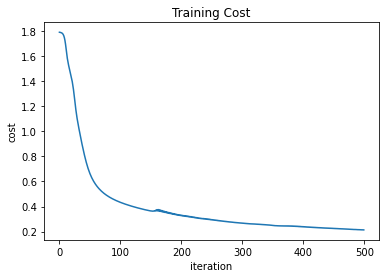

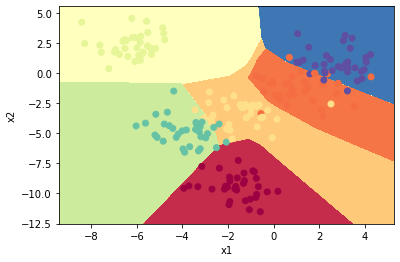

In [24]:
# Plot cost over iteration
plot_costs(costs)

# Plot the decision boundary
plot_decision_boundary(X, Y, nnmodel.predict)


Training accuracy should reach around 93% and the decision boundaries should look reasonable.  Feel free to change up the model or try different learning rates and training iterations.  Now that our framework appears to be working, we can start trying it on some real data.

## 3 Training on MNIST

We will start with the [MNIST](http://yann.lecun.com/exdb/mnist/) image data set of handwritten digits. This dataset contains 10 classes, one for each digit. Images are 28x28 pixel grayscale images.  We will flatten these images into feature vectors (28*28=784 features per input). The data set has a training set with 60,000 images, and a test set with 10,000 images.

MNIST is now considered a toy dataset.  We will start with it to keep the models we try simple.  In the next assignment, we will move to more sophisticated data sets.

### 3.1. Preparing the Data

Run the following code to load the training and validation sets.  We will also normalize the input features to 0-1 to help with training. We will discuss data-preprocessing in a later lecture.


In [25]:
from a3_tools import plot_sample, one_hot, load_mnist, plot_training_and_validation_costs

X_train, Y_train, X_validation, Y_validation = load_mnist()

X_train = X_train.astype('float')
X_train = X_train/255

X_validation = X_validation.astype('float')
X_validation = X_validation/255

### 3.2. Look at the data

We have provided a function named *plot_sample()* which will plot n samples from each class. Run the following code to see what the data set looks like.


X (training)   shape: (784, 60000)
Y (training)   shape: (60000,)
X (validation) shape: (784, 10000)
Y (validation) shape: (10000,)


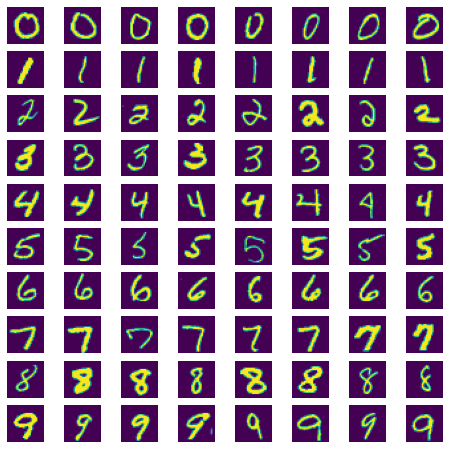

In [26]:
print("X (training)   shape:", X_train.shape)
print("Y (training)   shape:", Y_train.shape)
print("X (validation) shape:", X_validation.shape)
print("Y (validation) shape:", Y_validation.shape)

plot_sample(X_train, Y_train, (28, 28), 10, n=8)


The labels are not yet one-hot encoded.  Use function *one\_hot()* function in $a3\_tools$ to perform one-hot encoding.  The function accepts the original array, and a number to specify the number of classes.


In [27]:
Y_train = one_hot(Y_train, 10)
Y_validation = one_hot(Y_validation, 10)

print("Y (training)   shape:", Y_train.shape)
print("Y (validation) shape:", Y_validation.shape)
print()

Y (training)   shape: (10, 60000)
Y (validation) shape: (10, 10000)



### 3.3 Train a model

We will again start by training a very simple model with only 2 layers. We will also supply the validation set to the training so that we can see how well the model generalizes.


0 loss: 2.30239739 - accuracy: 0.080 - val_loss: 2.30241668 - val_accuracy: 0.080
1 loss: 2.30231332 - accuracy: 0.096 - val_loss: 2.30233097 - val_accuracy: 0.093
2 loss: 2.30222767 - accuracy: 0.108 - val_loss: 2.30224365 - val_accuracy: 0.106
3 loss: 2.30213999 - accuracy: 0.114 - val_loss: 2.30215440 - val_accuracy: 0.117
4 loss: 2.30204976 - accuracy: 0.113 - val_loss: 2.30206266 - val_accuracy: 0.114
5 loss: 2.30195647 - accuracy: 0.112 - val_loss: 2.30196791 - val_accuracy: 0.114
6 loss: 2.30185958 - accuracy: 0.112 - val_loss: 2.30186955 - val_accuracy: 0.114
7 loss: 2.30175857 - accuracy: 0.112 - val_loss: 2.30176695 - val_accuracy: 0.114
8 loss: 2.30165284 - accuracy: 0.112 - val_loss: 2.30165940 - val_accuracy: 0.114
9 loss: 2.30154182 - accuracy: 0.112 - val_loss: 2.30154641 - val_accuracy: 0.114
10 loss: 2.30142485 - accuracy: 0.112 - val_loss: 2.30142731 - val_accuracy: 0.114
11 loss: 2.30130130 - accuracy: 0.112 - val_loss: 2.30130125 - val_accuracy: 0.114
12 loss: 2.301

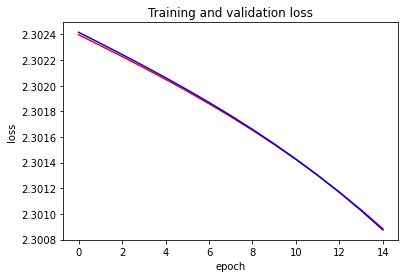

In [28]:
# Specify 10 output classes
n_c = 10

# Specify the model
nnmodel = Model([
    InputLayer(28*28),  # 784 Feature Input
    LinearLayer(10),    # 10 unit fully connected layer
    ReLULayer(),        # ReLU activation
    LinearLayer(n_c),   # 10 unit fully connected output layer
    SoftmaxLayer()])    # softmax activation

# Use Categorical Cross Entropy and compile compute graph
nnmodel.compile(loss=CategoricalCrossEntropyLoss())

# Train
costs_train, costs_test = nnmodel.train(X_train, 
                                        Y_train,
                                        validation_data=(X_validation, Y_validation),
                                        epochs=15,         # Training Iterations
                                        learning_rate=0.1, # Learning Rate
                                        print_freq=1)      # Number of iterations between printing progress

# Plot loss
plot_training_and_validation_costs(costs_train, costs_test)

You should be seeing very slow progress in training. It turns out that as you work with larger feature spaces and data set sizes, classic Gradient Descent becomes impractically slow for converging to good parameter values.  There have since been many new flavors of Gradient Descent which we will cover in detail later in the lectures.

For now, we simply present Mini-Batch Gradient Descent (also referred to as Stochastic Mini-Batch Gradient Descent) for your use. Intuitively, the only difference is that instead of updating the parameters after evaluating **all** training samples, Mini-Batch Gradient Descent updates the parameters after a subset (called a batch) of training samples. In practice, batch sizes may be something like 32-256 samples. One pass through the entire training set is called an epoch. Each parameter update now only minimizes average loss for the batch and not necessarily for all training samples. However, the increase in number of updates within an epoch is significant, and overall, will lead to faster convergence. Specifically, there are $\frac{training\_set\_size}{batch\_size}$ updates per epoch. For the MNIST data set and batch sizes of 128, this is about 470 updates (60000/128) updates per epoch, compared to 1 for classic Gradient Descent.

Note that with a batch size equal to the training set size, Mini-Batch Gradient Descent is the same as classic Gradient Descent.


### 3.4 Train Using Mini-Batch Gradient Descent

Let's train the same model now using the $train\_sgd()$ function provided for you.  You should see significant improvement in the progress per epoch. 


0 loss: 0.43487871 - accuracy: 0.868 - val_loss: 0.42000553 - val_accuracy: 0.870
1 loss: 0.34884950 - accuracy: 0.896 - val_loss: 0.34163357 - val_accuracy: 0.898
2 loss: 0.31831296 - accuracy: 0.906 - val_loss: 0.31546144 - val_accuracy: 0.906
3 loss: 0.30223601 - accuracy: 0.912 - val_loss: 0.30271758 - val_accuracy: 0.912
4 loss: 0.28916870 - accuracy: 0.916 - val_loss: 0.29214900 - val_accuracy: 0.914
5 loss: 0.27545072 - accuracy: 0.920 - val_loss: 0.28007778 - val_accuracy: 0.917
6 loss: 0.26269727 - accuracy: 0.924 - val_loss: 0.26833779 - val_accuracy: 0.921
7 loss: 0.25305436 - accuracy: 0.927 - val_loss: 0.25977434 - val_accuracy: 0.923
8 loss: 0.24447324 - accuracy: 0.929 - val_loss: 0.25216810 - val_accuracy: 0.927
9 loss: 0.23833380 - accuracy: 0.931 - val_loss: 0.24685877 - val_accuracy: 0.928
10 loss: 0.23326506 - accuracy: 0.933 - val_loss: 0.24249183 - val_accuracy: 0.929
11 loss: 0.22874633 - accuracy: 0.934 - val_loss: 0.23852105 - val_accuracy: 0.929
12 loss: 0.224

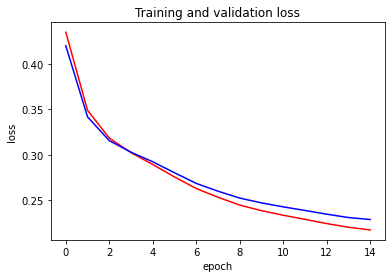

In [29]:
# Specify 10 output classes
n_c = 10

# Specify the model
nnmodel = Model([
    InputLayer(28*28),  # 784 Feature Input
    LinearLayer(10),    # 10 unit fully connected layer
    ReLULayer(),        # ReLU activation
    LinearLayer(n_c),   # 10 unit fully connected output layer
    SoftmaxLayer()])    # softmax activation

# Use Categorical Cross Entropy and compile compute graph
nnmodel.compile(loss=CategoricalCrossEntropyLoss())

# Train using Mini Batch Gradient Descent
costs_train, costs_test = nnmodel.train_sgd(X_train, 
                                            Y_train, 
                                            validation_data=(X_validation, Y_validation),
                                            epochs=15,         # Training Epochs
                                            learning_rate=0.1, # Learning Rate
                                            batch_size=128,    # Mini-Batch Gradient Descent batch size
                                            print_freq=1)      # Number of iterations between printing progress

# Plot loss
plot_training_and_validation_costs(costs_train, costs_test)

### 3.5 Deeper Networks

You should be seeing about 92-93% accuracy for both training and validation in the previous network. This seems pretty good but it turns out you can do better.  Let's try creating a deeper and bigger network. Try the following 3 layer network.


0 loss: 2.30073555 - accuracy: 0.112 - val_loss: 2.30061844 - val_accuracy: 0.114
1 loss: 2.26410715 - accuracy: 0.231 - val_loss: 2.26335521 - val_accuracy: 0.233
2 loss: 0.89228504 - accuracy: 0.719 - val_loss: 0.86996964 - val_accuracy: 0.730
3 loss: 0.58943570 - accuracy: 0.820 - val_loss: 0.57710207 - val_accuracy: 0.825
4 loss: 0.45295130 - accuracy: 0.864 - val_loss: 0.45154631 - val_accuracy: 0.862
5 loss: 0.37185128 - accuracy: 0.888 - val_loss: 0.37364343 - val_accuracy: 0.885
6 loss: 0.32053012 - accuracy: 0.903 - val_loss: 0.32662751 - val_accuracy: 0.900
7 loss: 0.27730896 - accuracy: 0.916 - val_loss: 0.28603403 - val_accuracy: 0.913
8 loss: 0.24298991 - accuracy: 0.926 - val_loss: 0.25341018 - val_accuracy: 0.921
9 loss: 0.21809252 - accuracy: 0.934 - val_loss: 0.22947559 - val_accuracy: 0.927
10 loss: 0.19466038 - accuracy: 0.941 - val_loss: 0.20595029 - val_accuracy: 0.935
11 loss: 0.17675294 - accuracy: 0.947 - val_loss: 0.18767502 - val_accuracy: 0.942
12 loss: 0.161

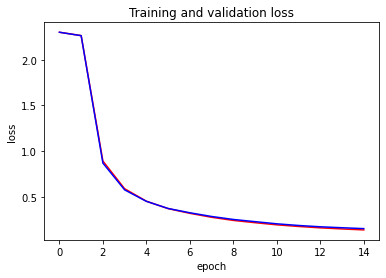

In [30]:
# Specify 10 output classes
n_c = 10

# Specify the model
nnmodel = Model([
    InputLayer(28*28), # 784 Feature Input
    LinearLayer(50),   # 10 unit fully connected layer
    ReLULayer(),       # ReLU activation
    LinearLayer(20),   # 10 unit fully connected layer
    ReLULayer(),       # ReLU activation
    LinearLayer(n_c),  # 10 unit fully connected layer
    SoftmaxLayer()])   # softmax activation

# Use Categorical Cross Entropy and compile compute graph
nnmodel.compile(loss=CategoricalCrossEntropyLoss())

# Train using Mini Batch Gradient Descent
costs_train, costs_test = nnmodel.train_sgd(X_train, 
                                            Y_train, 
                                            validation_data=(X_validation, Y_validation),
                                            epochs=15,          # Training Epochs
                                            learning_rate=0.05, # Learning Rate
                                            batch_size=128,     # Mini-Batch Gradient Descent batch size
                                            print_freq=1)       # Number of iterations between printing progress

# Plot loss
plot_training_and_validation_costs(costs_train, costs_test)

Ok accuracy improved to almost 96%.  You will find however, if you try to create deeper models, it will become more difficult to train.  Try adding more layers for example.  It turns out, there are other considerations that we need to worry about such as efficient weight initialization. We will go into these topics more.  But the takeaway here is that backpropagation doesn't magically make any deep network easy to train.

Feel free to play around with the above model to add more layers and see what happens.

## 4 Keras

In this section, we will give you a quick introduction to the Keras deep learning library which runs on top of TensorFlow.  Keras let's you work at a very high-level of abstraction where you can specify the types of layers you want and how they are organized (just like our framework!).  For many applications of deep learning where you simply want to try standard things, Keras is a quick way to test your ideas.  

### 4.1. A Quick Example

As we have modelled our framework to follow Keras' API, the follow example should look familiar.  We have configured the following model to be the same as the one we created in Section 3.4.  

A few differences to note:

- Keras refers to fully-connected linear layers as "Dense" layers
- *kernel_initializer* refers to how the parameters of the layer are initialized. In this example, we use the naive normal distribution.

We likely won't go into too much detail teaching you Keras in the course since after you learn the concepts that will be taught, Keras will be very intuitive.  If you want to read more about Keras now you can see:
https://keras.io/getting-started/sequential-model-guide/

Try running the following code block and you should see that the model is trained to a very similar level of quality as the one we created in Section 3.4. 


In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.initializers import RandomNormal, he_normal
from tensorflow.keras import optimizers

# Define a 2-layer fully connected neural network
model = Sequential([
    Input(28*28),
    Dense(10, kernel_initializer=RandomNormal(mean=0.0, stddev=0.01)),
    Activation('relu'),
    Dense(10, kernel_initializer=RandomNormal(mean=0.0, stddev=0.01)),
    Activation('softmax'),
])

# Compile the model to use categorial cross entropy loss, 
# and Mini-Batch Stochastic Gradient Descent Optimizer with a learning rate of 0.1
optimizer = optimizers.SGD(lr=0.1)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(X_train.T, 
                    Y_train.T, 
                    validation_data=(X_validation.T, Y_validation.T), 
                    epochs=15, 
                    batch_size=128)


2021-10-29 06:54:36.005608: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-29 06:54:36.579072: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-29 06:54:36.579814: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2194915000 Hz


Epoch 1/15
469/469 [==============================] - 2s 4ms/step - loss: 1.5889 - accuracy: 0.4699 - val_loss: 0.4168 - val_accuracy: 0.8793
Epoch 2/15
469/469 [==============================] - 1s 3ms/step - loss: 0.3930 - accuracy: 0.8882 - val_loss: 0.3183 - val_accuracy: 0.9064
Epoch 3/15
469/469 [==============================] - 1s 3ms/step - loss: 0.3239 - accuracy: 0.9067 - val_loss: 0.2933 - val_accuracy: 0.9163
Epoch 4/15
469/469 [==============================] - 1s 3ms/step - loss: 0.2942 - accuracy: 0.9146 - val_loss: 0.2788 - val_accuracy: 0.9196
Epoch 5/15
469/469 [==============================] - 1s 3ms/step - loss: 0.2746 - accuracy: 0.9203 - val_loss: 0.2662 - val_accuracy: 0.9234
Epoch 6/15
469/469 [==============================] - 1s 3ms/step - loss: 0.2678 - accuracy: 0.9234 - val_loss: 0.2619 - val_accuracy: 0.9249
Epoch 7/15
469/469 [==============================] - 1s 3ms/step - loss: 0.2584 - accuracy: 0.9257 - val_loss: 0.2566 - val_accuracy: 0.9277
Epoch 

The returned history object contains information per epoch that we can plot.  We have provided a function *plot_training_history()* to help extract and plot the accuracy and loss.

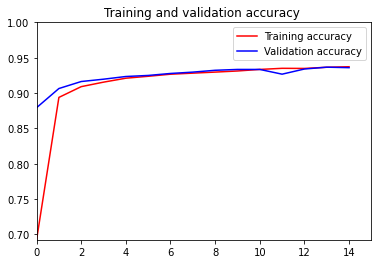

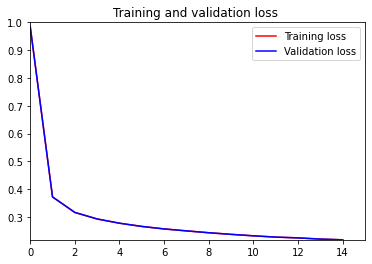

<Figure size 432x288 with 0 Axes>

In [32]:
from a3_tools import plot_training_history
plot_training_history(history)


### 4.2.  Deep Neural Networks

As a final exercise, follow the example in 4.1 to specify a fully connected neural network that can achieve 99.5% training accuracy on the MNIST data set. For this assignment, focus on architectural choices such as choosing

- Number of layers
- Number of units per layer
- Activation unit (sigmoid, tanh, relu)

Only use fully connected (Dense), and Activation layers. We have fixed the training parameters such as learning rate, number of epochs, and Gradient Descent batch-size.

As mentioned earlier, our naive random normal weight initialization doens't work well for deep networks.  We will talk about the different techniques later, but for now, you can try using the *He* weight initialization in Keras by specifying the following *kernel_initializer*. 

    kernel_initializer=he_normal()

In [33]:
# Graded Function: Keras

# We wrap this in a function for testability in the next cell
def train_keras_model():
    
    model = Sequential([
        Input(28*28),

    ### START CODE HERE ###
    # YOUR CODE HERE
        Dense(100, kernel_initializer=he_normal()), 
        Activation('relu'),
        Dense(100, kernel_initializer=he_normal()), 
        Activation('relu'),
        Dense(100, kernel_initializer=he_normal()), 
        Activation('relu'),
        Dense(100, kernel_initializer=he_normal()), 
        Activation('relu'),
        Dense(100, kernel_initializer=he_normal()), 
        Activation('relu'),
    ### END CODE HERE ###
        Dense(10, kernel_initializer=he_normal()), # 10 units for final softmax output
        Activation('softmax'),
    ])


    # Compile the model to use categorial cross entropy loss, 
    # and Mini-Batch Stochastic Gradient Descent Optimizer with a learning rate of 0.1
    optimizer = optimizers.SGD(lr=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train.T, 
                        Y_train.T, 
                        validation_data=(X_validation.T, Y_validation.T), 
                        epochs=15, 
                        batch_size=128)
    
    return history


# Run the keras model and training
_ = train_keras_model()

Epoch 1/15
469/469 [==============================] - 5s 10ms/step - loss: 0.7153 - accuracy: 0.7735 - val_loss: 0.2016 - val_accuracy: 0.9373
Epoch 2/15
469/469 [==============================] - 4s 9ms/step - loss: 0.1547 - accuracy: 0.9525 - val_loss: 0.1808 - val_accuracy: 0.9425
Epoch 3/15
469/469 [==============================] - 4s 9ms/step - loss: 0.1118 - accuracy: 0.9665 - val_loss: 0.1501 - val_accuracy: 0.9513
Epoch 4/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0869 - accuracy: 0.9731 - val_loss: 0.0951 - val_accuracy: 0.9690
Epoch 5/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0697 - accuracy: 0.9784 - val_loss: 0.1018 - val_accuracy: 0.9701
Epoch 6/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0530 - accuracy: 0.9830 - val_loss: 0.0904 - val_accuracy: 0.9719
Epoch 7/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0461 - accuracy: 0.9854 - val_loss: 0.0997 - val_accuracy: 0.9707
Epoch

In [34]:
def test_keras():
    """ Test that 99.5% training accuracy was achieved """
    history = train_keras_model()
    assert history.history['accuracy'][-1] > 0.995, "Did not achieve greater than 99.5% training accuracy."
    
    print("PASSED: Keras model")

# Run the keras test case
test_keras()

Epoch 1/15
469/469 [==============================] - 5s 10ms/step - loss: 0.7888 - accuracy: 0.7509 - val_loss: 0.2004 - val_accuracy: 0.9356
Epoch 2/15
469/469 [==============================] - 4s 9ms/step - loss: 0.1647 - accuracy: 0.9500 - val_loss: 0.1715 - val_accuracy: 0.9464
Epoch 3/15
469/469 [==============================] - 4s 9ms/step - loss: 0.1189 - accuracy: 0.9634 - val_loss: 0.1148 - val_accuracy: 0.9631
Epoch 4/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0904 - accuracy: 0.9716 - val_loss: 0.1106 - val_accuracy: 0.9639
Epoch 5/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0732 - accuracy: 0.9773 - val_loss: 0.1044 - val_accuracy: 0.9666
Epoch 6/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0580 - accuracy: 0.9816 - val_loss: 0.0881 - val_accuracy: 0.9736
Epoch 7/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0498 - accuracy: 0.9836 - val_loss: 0.0986 - val_accuracy: 0.9688
Epoch

## 5 Conclusion

Congratulations you are well on your way to building a deep neural network framework!  We will continue to extend this framework in subsequent assignments.

In this assignment, you have:

- Built a modular Neural Network framework that supports basic layer types and components.
- Implemented forward propagation and back propagation in a modular and vectorized fashion for common layer types.
- Implemented new functionalities such as ReLU activation, softmax activation, and categorical cross entropy loss.
- Built a multiclass classifier for both structured and unstructured image data.
- Explored limitations of classic Gradient Descent, and naive weight initialization for deep neural networks.
- Worked with a real dataset (MNIST) and applied training and validation data sets to evaluate a model
- Used Keras to build and train basic neural networks

Thank you to Singulos Research for feedback, suggestions, and testing of this assignment.